# 1 - Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime

# 2 - Settings

In [3]:
settings = {
    "measure": None,
    "blocks": 7,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "gkp",
        "delta": 0.4,
        "logical_state": "-y"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 41,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}


if settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]
    title = f"GKP Squeezing level: {squeezing_level:.2f} dB"


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 3 - Helpers

In [4]:
def run_circuit(params, N, measure=settings["measure"]):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
        cirq.append(jqtc.Rx(jnp.pi), 0)
    
    if measure == 'x':
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")
        cirq.append(jqtc.Ry(-jnp.pi/2), 0)
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        
    if measure == 'z':
        cirq.append(jqtc.MZ_plus(), 0, default_simulate_mode="kraus")
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()
    

def fid_metric(params, target_state):
    N = target_state.dims[0][1]
    prepared_state = run_circuit(params, N)
    return jnp.real(jqt.overlap(target_state, prepared_state))

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0, None))


def regularize(params, mode='avg'):
    betas_re = params[2]
    betas_im = params[3]

    betas_amp = jnp.abs(betas_re + 1j*betas_im)

    if mode=='avg':
        reg_loss = settings["reg_strength"] * jnp.average(betas_amp**2)
    if mode=='max':
        reg_loss = settings["reg_strength"] * jnp.max(betas_amp)**2
        
    return reg_loss

regularize_vmap = jax.vmap(regularize, in_axes=(0, None))


def metric(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log10(1 - fids)
    #losses = 1.-fids
    avg_loss = losses
    reg_loss = regularize_vmap(params, settings['reg_mode'])
    
    return jnp.average(avg_loss + reg_loss)

def metric_non_avg(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log10(1 - fids)
    #losses = 1.-fids
    avg_loss = losses
    reg_loss = regularize_vmap(params, settings['reg_mode'])

    return avg_loss + reg_loss

    


def cf_tomography_circuit(state, beta, measure_real=True):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    
    if measure_real:
        cirq.append(jqtc.Ry(jnp.pi/2), 0)
    else:
        cirq.append(jqtc.Rx(jnp.pi/2), 0)

    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state, betas_re=None, betas_im=None):
    if len(osc_state.dims[0]) == 1:
        if osc_state.is_dm():
            state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
        else:
            state = jqt.basis(2,0) ^ osc_state
    else:
        state = osc_state

    # Plot CF
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 101)
    betas_im = betas_re if betas_re is not None else  jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=True)))
    tomo_res_real = cf_tomography_circuit_vmap(betas_flat)

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=False)))
    tomo_res_imag = cf_tomography_circuit_vmap(betas_flat)
    
    tomo_res_real = tomo_res_real.reshape(*betas.shape)
    tomo_res_imag = tomo_res_imag.reshape(*betas.shape)

    tomo_res = tomo_res_real + 1j*tomo_res_imag

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


# 4 - Batch Gradient Descent

In [5]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [6]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
metric_non_avg_jit = jit(metric_non_avg)
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

30.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
341 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
92.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
start_learning_rate = settings["learning_rate"]
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []
metric_batch_history = []

epochs = settings["epochs"]
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params, settings["target_state"]))
  metric_batch_history.append(metric_non_avg_jit(params, settings['target_state']))
  metrics, grads = metric_val_and_grad(params, settings["target_state"])
  metric_history.append(metrics)

    
  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metrics:.4f}, best fid = {jnp.max(fids_history[-1])}")

    if settings["minimize_metric"] == False:
        fids_history_array = jnp.array(fids_history)
        log_infid_history = jnp.log10(1-fids_history_array)
        best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
        best_fid =fids_history_array[best_fid_epoch_indx, best_fid_batch_indx]
    
        best_params = params_history[best_fid_epoch_indx][best_fid_batch_indx]
        np.savez(settings["data_filename"], settings=settings, best_params=best_params) # TODO: maybe save fids and parameter histories too?
    else:
        metric_history_array = jnp.array(metric_batch_history)
        best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(metric_history_array), metric_history_array.shape)
        best_metric =metric_history_array[best_metric_epoch_indx, best_metric_batch_indx]
    
        best_params = params_history[best_metric_epoch_indx][best_metric_batch_indx]
        np.savez(settings["data_filename"], settings=settings, best_params=best_params)


  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


# Final Save ----

fids_history = jnp.array(fids_history)
params_history = jnp.array(params_history)
metric_history = jnp.array(metric_history)

if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]

np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

Epoch 0: metric = 5.3868, best fid = 0.15488828401672333


  1%|▉                                                                                | 11/1000 [00:17<11:29,  1.44it/s]

Epoch 10: metric = 5.1595, best fid = 0.36509497462123186


  2%|█▌                                                                               | 20/1000 [00:22<08:25,  1.94it/s]

Epoch 20: metric = 4.9326, best fid = 0.5129402421229768


  3%|██▌                                                                              | 31/1000 [00:28<09:46,  1.65it/s]

Epoch 30: metric = 4.7107, best fid = 0.6530793490722129


  4%|███▎                                                                             | 41/1000 [00:33<09:40,  1.65it/s]

Epoch 40: metric = 4.4961, best fid = 0.7396820561577206


  5%|████▏                                                                            | 51/1000 [00:38<09:33,  1.65it/s]

Epoch 50: metric = 4.2898, best fid = 0.7557357528191897


  6%|████▉                                                                            | 61/1000 [00:44<09:31,  1.64it/s]

Epoch 60: metric = 4.0939, best fid = 0.7859997467148645


  7%|█████▊                                                                           | 71/1000 [00:49<09:24,  1.65it/s]

Epoch 70: metric = 3.9078, best fid = 0.8238388196378497


  8%|██████▌                                                                          | 81/1000 [00:54<09:10,  1.67it/s]

Epoch 80: metric = 3.7304, best fid = 0.841142682356458


  9%|███████▎                                                                         | 91/1000 [00:59<09:04,  1.67it/s]

Epoch 90: metric = 3.5613, best fid = 0.8495452090223342


 10%|████████                                                                        | 101/1000 [01:05<08:58,  1.67it/s]

Epoch 100: metric = 3.3991, best fid = 0.8537189936493108


 11%|████████▉                                                                       | 111/1000 [01:10<08:52,  1.67it/s]

Epoch 110: metric = 3.2427, best fid = 0.8568146873703709


 12%|█████████▋                                                                      | 121/1000 [01:15<08:47,  1.67it/s]

Epoch 120: metric = 3.0917, best fid = 0.8586725546732731


 13%|██████████▍                                                                     | 131/1000 [01:20<08:43,  1.66it/s]

Epoch 130: metric = 2.9464, best fid = 0.8713382589595109


 14%|███████████▎                                                                    | 141/1000 [01:26<08:39,  1.65it/s]

Epoch 140: metric = 2.8072, best fid = 0.8840390771429105


 15%|████████████                                                                    | 151/1000 [01:31<08:32,  1.66it/s]

Epoch 150: metric = 2.6736, best fid = 0.8939588851722589


 16%|████████████▉                                                                   | 161/1000 [01:36<08:26,  1.66it/s]

Epoch 160: metric = 2.5454, best fid = 0.9023474681439214


 17%|█████████████▋                                                                  | 171/1000 [01:42<08:20,  1.66it/s]

Epoch 170: metric = 2.4217, best fid = 0.9106484566163127


 18%|██████████████▍                                                                 | 181/1000 [01:47<08:16,  1.65it/s]

Epoch 180: metric = 2.3021, best fid = 0.9189860651452237


 19%|███████████████▎                                                                | 191/1000 [01:52<08:09,  1.65it/s]

Epoch 190: metric = 2.1874, best fid = 0.924814157978957


 20%|████████████████                                                                | 201/1000 [01:57<08:04,  1.65it/s]

Epoch 200: metric = 2.0768, best fid = 0.9263811455297475


 21%|████████████████▉                                                               | 211/1000 [02:03<07:59,  1.65it/s]

Epoch 210: metric = 1.9701, best fid = 0.9279234151558254


 22%|█████████████████▋                                                              | 221/1000 [02:08<07:53,  1.64it/s]

Epoch 220: metric = 1.8670, best fid = 0.9306712887750838


 23%|██████████████████▍                                                             | 231/1000 [02:13<07:47,  1.65it/s]

Epoch 230: metric = 1.7678, best fid = 0.9330689073197778


 24%|███████████████████▎                                                            | 241/1000 [02:19<07:44,  1.64it/s]

Epoch 240: metric = 1.6714, best fid = 0.9352644847505229


 25%|████████████████████                                                            | 251/1000 [02:24<07:36,  1.64it/s]

Epoch 250: metric = 1.5777, best fid = 0.9407456269835469


 26%|████████████████████▊                                                           | 260/1000 [02:28<06:18,  1.95it/s]

Epoch 260: metric = 1.4869, best fid = 0.9451565421734931


 27%|█████████████████████▋                                                          | 271/1000 [02:35<07:22,  1.65it/s]

Epoch 270: metric = 1.3995, best fid = 0.9483042850676776


 28%|██████████████████████▍                                                         | 280/1000 [02:39<06:08,  1.95it/s]

Epoch 280: metric = 1.3157, best fid = 0.9503820621401996


 29%|███████████████████████▏                                                        | 290/1000 [02:44<06:03,  1.95it/s]

Epoch 290: metric = 1.2349, best fid = 0.9516843374924698


 30%|████████████████████████                                                        | 300/1000 [02:50<05:58,  1.95it/s]

Epoch 300: metric = 1.1569, best fid = 0.9525168586827926


 31%|████████████████████████▊                                                       | 310/1000 [02:55<05:53,  1.95it/s]

Epoch 310: metric = 1.0813, best fid = 0.9530862104285572


 32%|█████████████████████████▌                                                      | 320/1000 [03:00<05:48,  1.95it/s]

Epoch 320: metric = 1.0079, best fid = 0.9534998294180621


 33%|██████████████████████████▍                                                     | 330/1000 [03:06<05:43,  1.95it/s]

Epoch 330: metric = 0.9377, best fid = 0.9538196860342121


 34%|███████████████████████████▏                                                    | 340/1000 [03:11<05:38,  1.95it/s]

Epoch 340: metric = 0.8708, best fid = 0.9540710349927247


 35%|████████████████████████████                                                    | 350/1000 [03:16<05:33,  1.95it/s]

Epoch 350: metric = 0.8068, best fid = 0.9542782924891108


 36%|████████████████████████████▊                                                   | 360/1000 [03:22<05:28,  1.95it/s]

Epoch 360: metric = 0.7454, best fid = 0.9544390450711219


 37%|█████████████████████████████▌                                                  | 370/1000 [03:27<05:23,  1.95it/s]

Epoch 370: metric = 0.6863, best fid = 0.9545542058593541


 38%|██████████████████████████████▍                                                 | 380/1000 [03:32<05:17,  1.95it/s]

Epoch 380: metric = 0.6298, best fid = 0.9546396195964278


 39%|███████████████████████████████▏                                                | 390/1000 [03:38<05:12,  1.95it/s]

Epoch 390: metric = 0.5755, best fid = 0.9547039463576282


 40%|████████████████████████████████                                                | 400/1000 [03:43<05:07,  1.95it/s]

Epoch 400: metric = 0.5233, best fid = 0.9547475442701507


 41%|████████████████████████████████▊                                               | 410/1000 [03:48<05:02,  1.95it/s]

Epoch 410: metric = 0.4740, best fid = 0.9548449278426477


 42%|█████████████████████████████████▌                                              | 420/1000 [03:54<04:57,  1.95it/s]

Epoch 420: metric = 0.4265, best fid = 0.9549732652628306


 43%|██████████████████████████████████▍                                             | 430/1000 [03:59<04:52,  1.95it/s]

Epoch 430: metric = 0.3811, best fid = 0.955211802466278


 44%|███████████████████████████████████▏                                            | 440/1000 [04:04<04:47,  1.95it/s]

Epoch 440: metric = 0.3373, best fid = 0.9556276932435853


 45%|████████████████████████████████████                                            | 450/1000 [04:10<04:42,  1.95it/s]

Epoch 450: metric = 0.2951, best fid = 0.9563556968755204


 46%|████████████████████████████████████▊                                           | 460/1000 [04:15<04:37,  1.95it/s]

Epoch 460: metric = 0.2541, best fid = 0.9573803514003654


 47%|█████████████████████████████████████▌                                          | 470/1000 [04:20<04:31,  1.95it/s]

Epoch 470: metric = 0.2151, best fid = 0.9585441780750283


 48%|██████████████████████████████████████▍                                         | 480/1000 [04:26<04:26,  1.95it/s]

Epoch 480: metric = 0.1780, best fid = 0.9594544798489667


 49%|███████████████████████████████████████▏                                        | 490/1000 [04:31<04:21,  1.95it/s]

Epoch 490: metric = 0.1430, best fid = 0.959823601828352


 50%|████████████████████████████████████████                                        | 500/1000 [04:36<04:16,  1.95it/s]

Epoch 500: metric = 0.1093, best fid = 0.9597999391564914


 51%|████████████████████████████████████████▊                                       | 510/1000 [04:42<04:11,  1.95it/s]

Epoch 510: metric = 0.0768, best fid = 0.9595169632762833


 52%|█████████████████████████████████████████▌                                      | 520/1000 [04:47<04:06,  1.95it/s]

Epoch 520: metric = 0.0457, best fid = 0.9708864579542533


 53%|██████████████████████████████████████████▍                                     | 530/1000 [04:52<04:00,  1.95it/s]

Epoch 530: metric = 0.0164, best fid = 0.9743469727121673


 54%|███████████████████████████████████████████▏                                    | 540/1000 [04:58<03:55,  1.95it/s]

Epoch 540: metric = -0.0119, best fid = 0.9754220199898817


 55%|████████████████████████████████████████████                                    | 550/1000 [05:03<03:50,  1.95it/s]

Epoch 550: metric = -0.0393, best fid = 0.9770220057375497


 56%|████████████████████████████████████████████▊                                   | 560/1000 [05:09<03:45,  1.95it/s]

Epoch 560: metric = -0.0653, best fid = 0.9777148987894517


 57%|█████████████████████████████████████████████▌                                  | 570/1000 [05:14<03:40,  1.95it/s]

Epoch 570: metric = -0.0900, best fid = 0.978209512486131


 58%|██████████████████████████████████████████████▍                                 | 580/1000 [05:19<03:35,  1.95it/s]

Epoch 580: metric = -0.1135, best fid = 0.9786241482858675


 59%|███████████████████████████████████████████████▏                                | 590/1000 [05:25<03:30,  1.95it/s]

Epoch 590: metric = -0.1361, best fid = 0.9789338851861051


 60%|████████████████████████████████████████████████                                | 600/1000 [05:30<03:25,  1.95it/s]

Epoch 600: metric = -0.1583, best fid = 0.9791162055222099


 61%|████████████████████████████████████████████████▊                               | 610/1000 [05:35<03:20,  1.95it/s]

Epoch 610: metric = -0.1799, best fid = 0.9792152002830656


 62%|█████████████████████████████████████████████████▌                              | 620/1000 [05:41<03:14,  1.95it/s]

Epoch 620: metric = -0.2004, best fid = 0.9792773227779683


 63%|██████████████████████████████████████████████████▍                             | 630/1000 [05:46<03:09,  1.95it/s]

Epoch 630: metric = -0.2200, best fid = 0.9793110539008428


 64%|███████████████████████████████████████████████████▏                            | 640/1000 [05:51<03:04,  1.95it/s]

Epoch 640: metric = -0.2384, best fid = 0.9793218910857686


 65%|████████████████████████████████████████████████████                            | 650/1000 [05:57<02:59,  1.95it/s]

Epoch 650: metric = -0.2560, best fid = 0.9792879728102234


 66%|████████████████████████████████████████████████████▊                           | 660/1000 [06:02<02:54,  1.95it/s]

Epoch 660: metric = -0.2729, best fid = 0.9793076733299172


 67%|█████████████████████████████████████████████████████▌                          | 670/1000 [06:08<02:49,  1.95it/s]

Epoch 670: metric = -0.2890, best fid = 0.9792958715047546


 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [06:13<02:44,  1.95it/s]

Epoch 680: metric = -0.3043, best fid = 0.979380446761789


 69%|███████████████████████████████████████████████████████▏                        | 690/1000 [06:18<02:39,  1.95it/s]

Epoch 690: metric = -0.3191, best fid = 0.9817111067333878


 70%|████████████████████████████████████████████████████████                        | 700/1000 [06:24<02:33,  1.95it/s]

Epoch 700: metric = -0.3331, best fid = 0.9831340953686627


 71%|████████████████████████████████████████████████████████▊                       | 710/1000 [06:29<02:28,  1.95it/s]

Epoch 710: metric = -0.3463, best fid = 0.983419026244327


 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [06:34<02:23,  1.95it/s]

Epoch 720: metric = -0.3591, best fid = 0.9833041016564608


 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [06:40<02:18,  1.95it/s]

Epoch 730: metric = -0.3715, best fid = 0.9832102550175428


 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [06:45<02:13,  1.95it/s]

Epoch 740: metric = -0.3835, best fid = 0.9831669152375325


 75%|████████████████████████████████████████████████████████████                    | 750/1000 [06:51<02:08,  1.95it/s]

Epoch 750: metric = -0.3950, best fid = 0.983164346408989


 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [06:56<02:03,  1.95it/s]

Epoch 760: metric = -0.4058, best fid = 0.9831214156905264


 77%|█████████████████████████████████████████████████████████████▌                  | 770/1000 [07:01<01:58,  1.95it/s]

Epoch 770: metric = -0.4159, best fid = 0.983094828986747


 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [07:07<01:52,  1.95it/s]

Epoch 780: metric = -0.4256, best fid = 0.9830592343080907


 79%|███████████████████████████████████████████████████████████████▏                | 790/1000 [07:12<01:47,  1.95it/s]

Epoch 790: metric = -0.4350, best fid = 0.9830230539655985


 80%|████████████████████████████████████████████████████████████████                | 800/1000 [07:18<01:42,  1.95it/s]

Epoch 800: metric = -0.4441, best fid = 0.9829922810955725


 81%|████████████████████████████████████████████████████████████████▊               | 810/1000 [07:23<01:37,  1.95it/s]

Epoch 810: metric = -0.4527, best fid = 0.9829642857733898


 82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [07:28<01:32,  1.95it/s]

Epoch 820: metric = -0.4610, best fid = 0.9829369066920537


 83%|██████████████████████████████████████████████████████████████████▍             | 830/1000 [07:34<01:27,  1.95it/s]

Epoch 830: metric = -0.4692, best fid = 0.9829108542476046


 84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [07:39<01:22,  1.95it/s]

Epoch 840: metric = -0.4771, best fid = 0.9828866127517036


 85%|████████████████████████████████████████████████████████████████████            | 850/1000 [07:44<01:17,  1.95it/s]

Epoch 850: metric = -0.4848, best fid = 0.9828638084905025


 86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [07:50<01:11,  1.95it/s]

Epoch 860: metric = -0.4924, best fid = 0.9827993953656206


 87%|█████████████████████████████████████████████████████████████████████▌          | 870/1000 [07:55<01:06,  1.94it/s]

Epoch 870: metric = -0.4999, best fid = 0.9827755890505732


 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [08:01<01:01,  1.95it/s]

Epoch 880: metric = -0.5073, best fid = 0.9827923845049743


 89%|███████████████████████████████████████████████████████████████████████▏        | 890/1000 [08:06<00:56,  1.95it/s]

Epoch 890: metric = -0.5143, best fid = 0.9827875317560311


 90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [08:11<00:51,  1.95it/s]

Epoch 900: metric = -0.5210, best fid = 0.9827764680946416


 91%|████████████████████████████████████████████████████████████████████████▊       | 910/1000 [08:17<00:46,  1.94it/s]

Epoch 910: metric = -0.5272, best fid = 0.9827642495949934


 92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [08:22<00:41,  1.95it/s]

Epoch 920: metric = -0.5331, best fid = 0.9827535037449572


 93%|██████████████████████████████████████████████████████████████████████████▍     | 930/1000 [08:28<00:35,  1.95it/s]

Epoch 930: metric = -0.5387, best fid = 0.9827441760963668


 94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [08:33<00:30,  1.95it/s]

Epoch 940: metric = -0.5443, best fid = 0.9827357706230075


 95%|████████████████████████████████████████████████████████████████████████████    | 950/1000 [08:38<00:25,  1.95it/s]

Epoch 950: metric = -0.5497, best fid = 0.9827285818018489


 96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [08:44<00:20,  1.95it/s]

Epoch 960: metric = -0.5551, best fid = 0.9827223219673583


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [08:49<00:15,  1.95it/s]

Epoch 970: metric = -0.5602, best fid = 0.9827169071414303


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [08:55<00:10,  1.95it/s]

Epoch 980: metric = -0.5649, best fid = 0.9829594026509076


 99%|███████████████████████████████████████████████████████████████████████████████▏| 990/1000 [09:00<00:05,  1.95it/s]

Epoch 990: metric = -0.5693, best fid = 0.9829272330458863


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:06<00:00,  1.83it/s]


In [29]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [30]:

best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

Regularization loss: 0.510
Total loss: -1.187


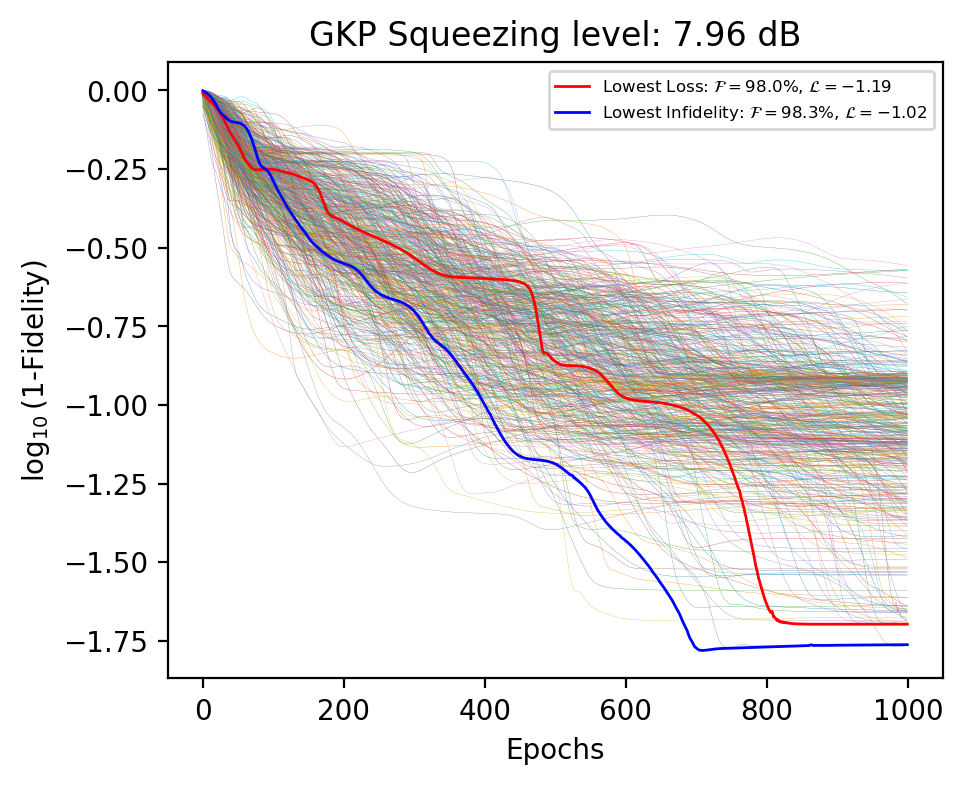

In [34]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(title)
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)
print(f"Regularization loss: {regularize(best_params):.3f}")
print(f"Total loss: {metric(jnp.array([best_params]), settings['target_state']):.3f}")

# 5 - Plotting Optimal

### (optionally) Load old params

In [5]:
data=np.load(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_gkp_state_prep.npz", allow_pickle=True)
optimal_instructions = data["best_params"]

best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

prepared_state = run_circuit(best_params, 100)

### Plot

In [6]:
def qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    beta_squared = np.abs(beta_squared)
    theta = ξ2 * beta_squared + ξ4 * beta_squared**2
    sx = np.cos(2*theta)
    sy = np.sin(2*theta)
    purity_scale_factor = (1 - (η0 + η2 *beta_squared + η4 * beta_squared**2 + η6 * beta_squared**3))
    return sx * purity_scale_factor + offset, sy * purity_scale_factor + offset

def purity_func(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    sx, sy = qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset)
    return 0.5 * (1 + sx**2 + sy**2)

def calculate_envelope(betas_re, betas_im, fit_vals):
    betas_re_grid, betas_im_grid = jnp.meshgrid(betas_re, betas_im)
    betas_squared_grid = jnp.abs(betas_re_grid)**2 + jnp.abs(betas_im_grid)**2
    purity_vals = purity_func(betas_squared_grid, *fit_vals)
    envelope = 2*(purity_vals-0.5)
    return envelope


fit_vals = (0.39097432835648155,
 0.034291746251959555,
 -0.0010010145791953715,
 1.0867037992914275e-05,
 -0.04611114282106909,
 9.382815933549335e-06,
 0.07836293463518865)

Best parameters: 
 [[ 0.742146  0.010352  0.189244  0.758436  0.748159  0.2504    0.745491]
 [ 0.873653  0.749459  0.236892  0.569389  0.517529  0.994647  0.248023]
 [-0.875134  0.694451 -0.683801  0.953733 -0.949875 -0.219034 -0.036801]
 [ 0.850947  0.73491   0.708465  0.924257  0.947102 -0.222962  0.001797]]


Text(0.5, 1.02, '20250710_h16m39s07_gkp_state_prep.npz, $\\vert-y\\rangle, \\Delta=0.4000$, $M=None$, $N_B=7$, $\\beta=0.5$')

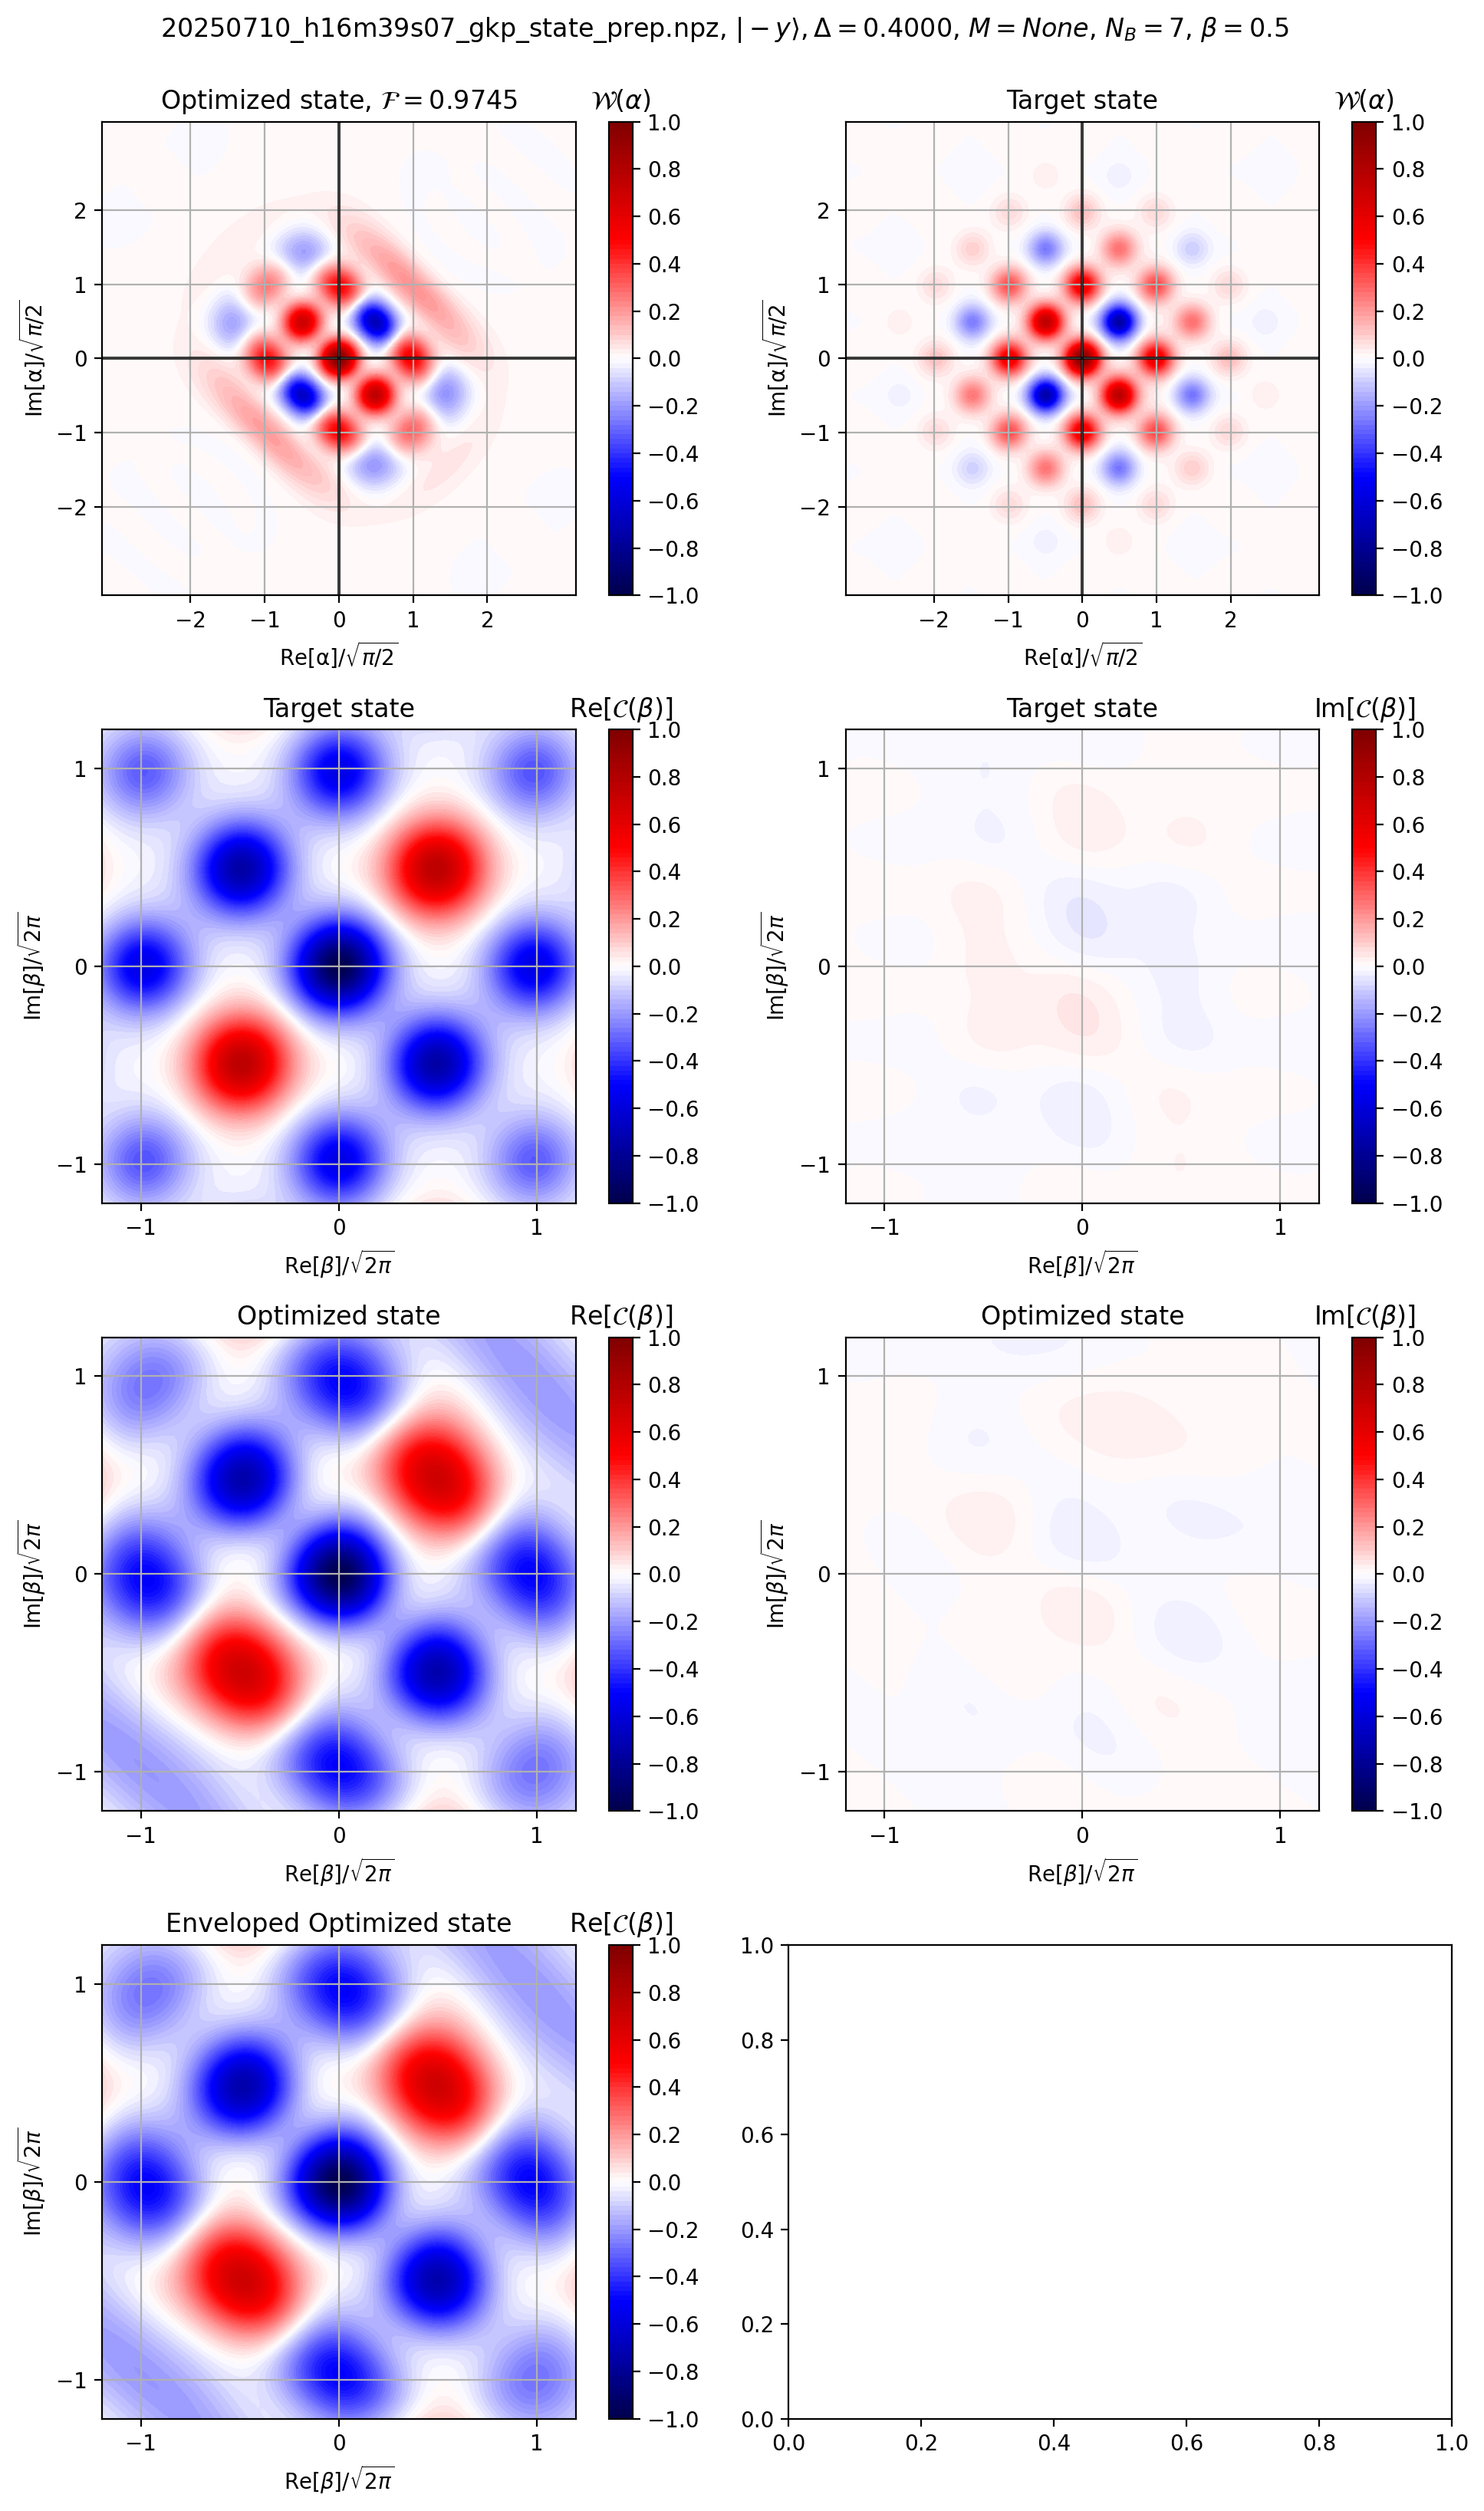

In [7]:
fig, axs = plt.subplots(4,2, dpi=200, figsize=(10,16))
axs = axs.flatten()
print("Best parameters: \n", best_params)

if settings["state"]["mode"] == "gkp":
    N_large = settings["N_large"]
    gkp_qubit_larger = jqtb.GKPQubit({"delta": settings["state"]["delta"], "N": N_large})
    target_state_larger = jqt.basis(2,0) ^ gkp_qubit_larger.basis[settings["state"]["logical_state"]]
 
prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(prepared_state,1), pts, ax=axs[0], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
# ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N={N}) Fidelity: {fid:.5f}")
ax.set_title(f"Optimized state, $\mathcal{{F}}={fid:.4f}$")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger.ptrace(1), pts, ax=axs[1], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title("Target state")


betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[4], axs[5])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")

envelope = calculate_envelope(betas_re, betas_im, fit_vals)

final_state = prepared_state
cf_vals, betas_re, betas_im = sim_cf(final_state, betas_re, betas_im)
#cf_vals = envelope * cf_vals

for j, ax in enumerate([axs[6]]):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Enveloped Optimized state")

fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['logical_state']}\\rangle, \\Delta={delta:.4f}$, $M={settings['measure']}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [8]:
np.savez(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_cf_noenv_data_QCPR.npz", cf=-cf_vals_plot.T, betas_re=betas_re, betas_im=betas_im)

Text(0.5, 1.0, 'Enveloped Optimized state')

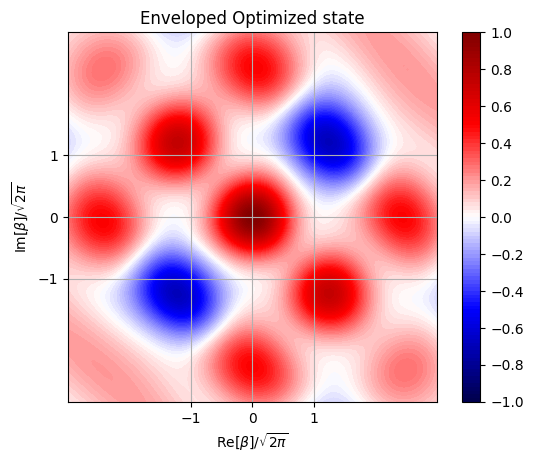

In [9]:
data=np.load(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_cf_noenv_data_QCPR.npz", allow_pickle=True)
cf = data["cf"]
betas_re = data["betas_re"]
betas_im = data["betas_im"]

fig, ax = plt.subplots(1)

im = ax.contourf(betas_re, betas_im, cf, levels=np.linspace(-1, 1, 101), cmap="seismic")
ax.set_aspect("equal", adjustable="box")
ax.grid()

ax.set_xticks([-1,0, 1])
ax.set_yticks([-1,0, 1])
ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

cbar = plt.colorbar(im, ax=ax, orientation="vertical")

cbar.ax.set_yticks(np.linspace(-1, 1, 11))

ax.set_title(r"Enveloped Optimized state")